In [121]:
import os
import numpy as np
from scipy.io import loadmat
import h5py
from preproc import *
from priordist import PriorDistributionCell

In [122]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181102"

In [123]:
# Get list of cells under the day directory
os.system(f"sh ~/Documents/neural_decoding/Hippocampus_Decoding/get_cells.sh {day_dir}")
cell_list = list()
with open("cell_list.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())
os.system("rm cell_list.txt")

# Load data from rplparallel.mat object, extract trial markers, time stamps and session start timestamp
rp = h5py.File(prefix + day_dir + "/session01/rplparallel.mat")
rp = rp.get('rp').get('data')
trial_markers = np.array(rp.get('markers'))
cue_intervals = np.array(rp.get('timeStamps'))
session_start_time = np.round(np.array(rp.get('session_start_sec'))[0,0], 3)

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
cell_labels = list()
for cell_dir in cell_list:
    spk = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    spk = spk.get('timestamps').flatten() # spike timestamps is loaded in as a column vector
    spk = spk / 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)
    
    cell_name = cell_dir.split('/')
    array, channel, cell = cell_name[0][6:], cell_name[1][7:], cell_name[2][5:]
    if channel[0] == '0':
        channel = channel[1:]
    cell_labels.append(f'a{array}/ch{channel}/c{cell}')

# Load data from vmpv.mat object, extract session end timestamp
pv = h5py.File(prefix + day_dir + "/session01/1vmpv.mat")
pv = pv.get('pv').get('data')
session_end_time = np.round(np.array(pv.get('rplmaxtime'))[0,0], 3)

250 ms time bins, 1 s binning statistics

In [124]:
# Get poster numbers from trial markers, cue phase time intervals
trial_markers = trial_markers[0,:] % 10
trial_markers = trial_markers.astype(int)
cue_intervals = cue_intervals[0:2,:].T

# Generate time intervals for each trial
trial_intervals = np.empty_like(cue_intervals)
trial_intervals[:,0] = cue_intervals[:,0]
trial_intervals[:-1,1] = cue_intervals[1:,0]
trial_intervals[-1,1] = session_end_time

In [125]:
# Bin entire session into 1s time bins, aligned to the start of each cue phase for each trial
session_intervals = list()
delta = 1  # Size of time bin (in seconds)
for idx, intvl in enumerate(trial_intervals):
    trial_start, trial_end = intvl
    for time in np.arange(trial_start, trial_end - delta, delta):
        session_intervals.append(np.array([time, time + delta]))
session_intervals = np.array(session_intervals)

# Divide cue phases into 250 ms time bins
new_cue_intervals = np.empty((cue_intervals.shape[0], cue_intervals.shape[1], 4))
delta = 0.25  # Size of time bin (in seconds)
for num, intvl in enumerate(cue_intervals):
    st_time, ed_time = intvl
    for prd in range(int(1/delta)):
        new_cue_intervals[num,0,prd] = st_time + delta * prd
        new_cue_intervals[num,1,prd] = st_time + delta * (prd + 1)
cue_intervals = new_cue_intervals

In [126]:
# Get number of cells in dataset
num_cells = len(cell_labels)

# Slot spikes into cue phase intervals for each trial
spikecounts_per_trial = np.empty((cue_intervals.shape[0], num_cells, cue_intervals.shape[2]))
for prd in range(cue_intervals.shape[2]):
    spikecounts_per_trial[:,:,prd] = spike_counts_per_observation(cue_intervals[:,:,prd], spike_times)
spikecounts_per_trial *= 4

# Slot spikes into session time intervals
spikecounts_across_session = spike_counts_per_observation(session_intervals, spike_times)

In [127]:
# Sanity check
spikecounts_cue_phase = np.sum(spikecounts_per_trial, axis=2)

In [128]:
# Bin spike counts within each cell for entire sesion, and get firing rate thresholds used for binning
binned_spikes_across_session = np.empty_like(spikecounts_across_session)
binning_stats = list()
for col in range(spikecounts_across_session.shape[1]):
    binned_spikes_across_session[:,col] = bin_firing_rates_4(spikecounts_across_session[:,col])
    binning_stats.append(get_binning_stats_4(spikecounts_across_session[:,col]))

# Bin spike counts within each cell for cue phases
binned_spikes_per_trial = np.empty_like(spikecounts_per_trial)
for prd in range(spikecounts_per_trial.shape[2]):
    for col in range(spikecounts_per_trial.shape[1]):
        binned_spikes_per_trial[:,col,prd] = bin_firing_rates_4(spikecounts_per_trial[:,col,prd], stats=binning_stats[col])

In [129]:
def group_by_goal(timeseries: np.array, goals: np.array) -> list:
    num_goals = 6
    grouped = [np.empty((0, timeseries.shape[1])) for _ in range(num_goals)]
    for idx, goal in enumerate(goals):
        goal = int(goal - 1)
        grouped[goal] = np.vstack((grouped[goal], timeseries[idx,:]))
    return grouped

In [130]:
# Group cue phase spikes according to goal
responses_per_goal = list()
for prd in range(binned_spikes_per_trial.shape[2]):
    responses_per_goal.append(group_by_goal(binned_spikes_per_trial[:,:,prd], trial_markers))

# Get distribution of population responses across entire session
response_distribution_session = list()
for responses in responses_per_goal:
    response_distribution_session.append(PriorDistributionCell(binned_spikes_across_session, responses))

In [131]:
# Some important constants
num_goals = 6
num_cats = 4
num_prds = 4

In [132]:
# Shannon entropy across goals
goal_entropy = 0
for goal in range(num_goals):
    P_s = response_distribution_session[0].P_s(goal)
    goal_entropy -= P_s * np.log2(P_s)

print(goal_entropy)

2.565364163013027


In [133]:
np.log2(6)

2.584962500721156

In [134]:
# Unconditioned entropy of responses across entire session
session_entropy = np.zeros(num_cells)
for cell in range(num_cells):
    for cat in range(num_cats):
        P_r = response_distribution_session[0].P_r(cell, cat)
        if P_r != 0:
            session_entropy[cell] -= P_r * np.log2(P_r)

print(session_entropy)

[0.99318182 1.90069016 0.         0.         0.95391854 1.98117563
 1.95046907 1.92997278 1.98311588 1.54772149 1.98512185 0.
 0.        ]


In [135]:
# Conditioned entropy of responses per goal
goal_response_entropy = np.zeros((num_goals, num_cells, num_prds))
for prd in range(num_prds):
    for goal in range(num_goals):
        for cell in range(num_cells):
            for cat in range(num_cats):
                P_r_s = response_distribution_session[prd].P_r_s(cell, cat, goal)
                if P_r_s != 0:
                    goal_response_entropy[goal, cell, prd] -= P_r_s * np.log2(P_r_s)

In [136]:
# Information gain per stimulus (relative to entire session responses)
information_gain = np.zeros((num_goals, num_cells, num_prds))
for prd in range(num_prds):
    for goal in range(num_goals):
        for cell in range(num_cells):
            for cat in range(num_cats):
                P_r_s = response_distribution_session[prd].P_r_s(cell, cat, goal)
                P_r = response_distribution_session[prd].P_r(cell, cat)
                if P_r_s != 0:
                    information_gain[goal, cell, prd] += P_r_s * np.log2(P_r_s / P_r)

In [137]:
# Net information gain acrosss entire stimuli set
net_information_gain = np.zeros((num_cells, num_prds))
for prd in range(num_prds):
    for cell in range(num_cells):
        for goal in range(num_goals):
            I_s_R = information_gain[goal, cell, prd]
            P_s = response_distribution_session[prd].P_s(goal)
            net_information_gain[cell, prd] += P_s * I_s_R

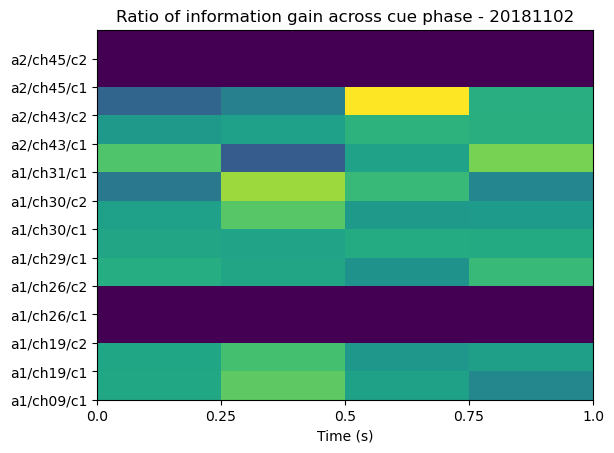

In [138]:
import matplotlib.pyplot as plt

def scale_values(arr: np.array) -> np.array:
    res = np.empty_like(arr)
    tot = np.sum(arr)
    if tot == 0:
        tot = 1
    for i, val in enumerate(arr):
        res[i] = val / tot
    return res

net_info_gain = np.empty_like(net_information_gain)
for idx, row in enumerate(net_information_gain):
    net_info_gain[idx,:] = scale_values(row)

plt.figure()
plt.pcolormesh(net_info_gain)
plt.title(f'Ratio of information gain across cue phase - {day_dir}')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, int(1/delta)+1), [delta * i for i in range(0, int(1/delta)+1)])
plt.yticks(np.arange(num_cells), cell_labels)
plt.show()

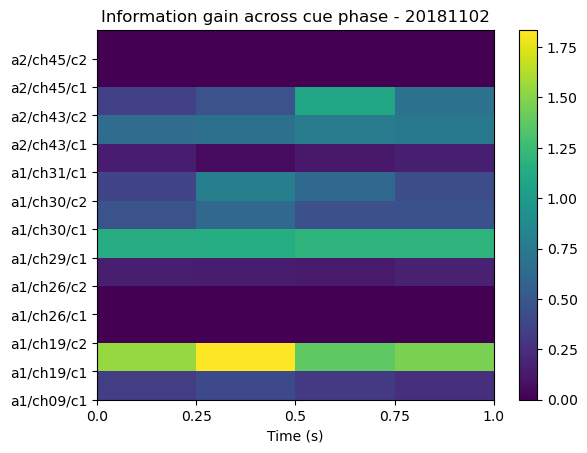

In [139]:
plt.figure()
plt.pcolormesh(net_information_gain)
plt.colorbar()
plt.title(f'Information gain across cue phase - {day_dir}')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, int(1/delta)+1), [delta * i for i in range(0, int(1/delta)+1)])
plt.yticks(np.arange(num_cells), cell_labels)
plt.show()